In [1]:
import jax
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from jax import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from heidelberg_v01 import plot_error, plot_spikes, plot_traces, run, run_example, load_data, load_datasets
from spikegd.theta import ThetaNeuron
from spikegd.utils.plotting import (
    cm2inch,
    panel_label,
)

In [2]:
plt.style.use("spikegd.utils.plotstyle")

In [3]:
jax.devices()

[CudaDevice(id=0)]

In [4]:
datasets = load_datasets("data", verbose=True)

Loading data from h5 file
Loading audio filenames
Finished loading SHD
Loading data from h5 file
Loading audio filenames
Finished loading SHD


# Run experiments

In [5]:
config_theta = {
    "seed": 0,
    # Neuron
    "tau": 6 / jnp.pi,
    "I0": 5 / 4,
    "eps": 1e-6,
    # Network
    # "Nin": 7000, # must be N * Nt, where N is the number of neurons in the SHD dataset (700)
    "Nin_virtual": 10,  # #Virtual input neurons = N_bin - 1
    "Nhidden": 50,
    "Nlayer": 3,  # Number of layers
    "Nout": 20,
    "w_scale": 0.5,  # Scaling factor of initial weights
    # Trial
    "T": 2.0,
    "K": 200,  # Maximal number of simulated ordinary spikes
    "dt": 0.001,  # Step size used to compute state traces
    # Training
    "gamma": 1e-2,
    "Nbatch": 1000,
    "lr": 4e-3,
    "tau_lr": 1e2,
    "beta1": 0.9,
    "beta2": 0.999,
    "p_flip": 0.0,
    "Nepochs": 10,
    "Ntrain": None, # Number of training samples

    # SHD Quantization
    "Nt": 10,

    "verbose": True,
}
Nin_data = 700
config_theta["Nin"] = Nin_data * config_theta["Nt"]


def run_theta(config: dict, data_loaders=None):
    """
    Wrapper to train a network of Theta neurons with the given configuration.

    See docstring of `run` and article for more information.
    """
    if data_loaders is None:
        data_loaders = load_data(datasets, config)

    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics, perf_metrics = run(neuron, data_loaders, config, progress_bar="notebook")
    return metrics, perf_metrics

In [6]:
def run_theta_ensemble(config: dict, samples: int = 1, data_loaders=None) -> dict:
    seed = 0
    key = random.PRNGKey(seed)
    seeds = random.randint(key, (samples,), 0, jnp.uint32(2**32 - 1), dtype=jnp.uint32)
    metrics_list = []

    # load data once if not provided
    if data_loaders is None:
        data_loaders = load_data(datasets, config)

    for seed in seeds:
        config_theta = {**config, "seed": seed}
        metrics, perf_metrics = run_theta(config_theta, data_loaders)
        metrics_list.append(metrics | perf_metrics)
    metrics = jax.tree.map(lambda *args: jnp.stack(args), *metrics_list)
    
    return metrics

metrics = run_theta_ensemble(config_theta, 3)
metrics_example = { key: value[0] for key, value in metrics.items() }

Max spike count in single time interval (19) is very different to N_bin (11)
Max spike count in single time interval (18) is very different to N_bin (11)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [7]:
def get_summary_metrics(metrics: dict, epoch: int = -1) -> dict:
    summary_metrics = {}

    for key, value in metrics.items():
        if key.startswith("perf."):
            # Not epoch-specific
            summary_metrics[key] = value
        elif key not in ["p_init", "p_end"]:
            # Epoch-specific
            summary_metrics[key] = value[:, epoch]

    return summary_metrics

def summarize_metrics(metrics: dict, epoch: int) -> None:
    """
    Print a summary of the metrics at the given epoch.
    """
    summary_metrics = get_summary_metrics(metrics, epoch)

    summary_metrics = jax.tree.map(
        lambda x: jnp.array([jnp.mean(x), jnp.std(x)]),
        summary_metrics,
    )
    for key, value in summary_metrics.items():
        print(f"{key:<25} {value[0]:.3f} ± {value[1]:.3f}")


print("**Results before training**")
summarize_metrics(metrics, 0)
print()
print("**Results after training**")
summarize_metrics(metrics, -1)

**Results before training**
acc                       0.054 ± 0.002
acc_ord                   0.046 ± 0.002
activity                  0.000 ± 0.000
activity_first            0.000 ± 0.000
loss                      3.040 ± 0.005
loss_ord                  3.013 ± 0.000
perf.compilation_time     0.001 ± 0.000
perf.optim_init_time      0.036 ± 0.046
perf.phi0_init_time       0.035 ± 0.048
perf.weights_init_time    0.280 ± 0.393
silent_neurons            0.980 ± 0.008
silent_neurons_first      0.980 ± 0.008

**Results after training**
acc                       0.735 ± 0.042
acc_ord                   0.100 ± 0.016
activity                  0.408 ± 0.026
activity_first            0.408 ± 0.025
loss                      0.912 ± 0.072
loss_ord                  3.010 ± 0.001
perf.compilation_time     0.001 ± 0.000
perf.optim_init_time      0.036 ± 0.046
perf.phi0_init_time       0.035 ± 0.048
perf.weights_init_time    0.280 ± 0.393
silent_neurons            0.063 ± 0.009
silent_neurons_first    

# Test error over time

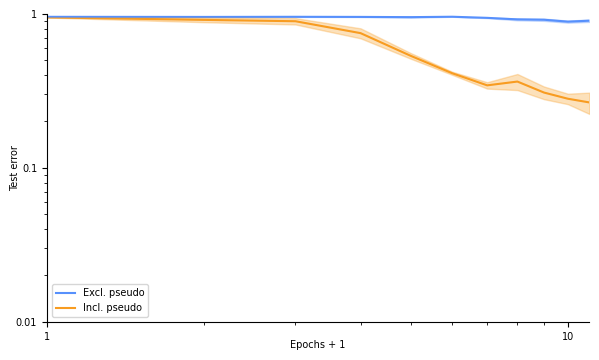

In [8]:
fig, ax = plt.subplots(figsize=(7, 4))
plot_error(ax, metrics, config_theta)

## Hyperparam tuning

In [9]:
import itertools
import time
from matplotlib.pylab import f
import pandas as pd
import numpy as np
import yaml

config_grid = {
    "seed": 0,
    # Neuron
    "tau": 6 / np.pi,
    "I0": 5 / 4,
    "eps": 1e-6,
    # Network
    # "Nin": 7000, # must be N * Nt, where N is the number of neurons in the SHD dataset (700)
    "Nin_virtual": (8, 16),  # #Virtual input neurons = N_bin - 1
    "Nhidden": (30, 50, 80),
    "Nlayer": (2, 3),  # Number of layers
    "Nout": 20,
    "w_scale": 0.5,  # Scaling factor of initial weights
    # Trial
    "T": 2.0,
    "K": (100, 200),  # Maximal number of simulated ordinary spikes
    "dt": 0.001,  # Step size used to compute state traces
    # Training
    "gamma": 1e-2,
    "Nbatch": 1000,
    "lr": 4e-3,
    "tau_lr": 1e2,
    "beta1": 0.9,
    "beta2": 0.999,
    "p_flip": 0.0,
    "Nepochs": 10,
    "Ntrain": None, # Number of training samples

    # SHD Quantization
    "Nt": (8, 16, 24),
}

def split_config(config: dict):
    const_config = {k: v for k, v in config.items() if not isinstance(v, tuple)}

    config_grid = {k: v for k, v in config.items() if isinstance(v, tuple)}

    grid_configs = [
        dict(zip(config_grid.keys(), values))
        for values in itertools.product(*config_grid.values())
    ]

    if "Nt" not in const_config:
        Nin_data = 700
        for grid_config in grid_configs:
            grid_config["Nin"] = Nin_data * grid_config["Nt"]

    return const_config, grid_configs


def run_theta_grid(config_grid, samples_per_config=1, filename=None):
    const_config, grid_configs = split_config(config_grid)
    
    if filename is None:
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        filename = f"grid_results_{timestamp}.yaml"
        results = {
            "timestamp": timestamp,
            "const": const_config,
        }
        with open(filename, "w") as f:
            yaml.dump(results, f, sort_keys=False)
        
        trial_count = 0
        print(f"Writing to new file {filename}.")
    else:
        if filename == "latest":
            from glob import glob
            filename = max(glob("grid_results_*.yaml"))

        with open(filename, "r") as f:
            results = yaml.safe_load(f)

        if results["const"] != const_config:
            raise ValueError("Cannot append to existing file with different constant config.")
        
        trial_count = len([key for key in results.keys() if key.startswith("trial_")])
        print(f"Appending to existing file {filename} with {trial_count} trials.")

    for i, grid_config in enumerate(grid_configs):
        trial_index = i + trial_count
        print(f"========== CONFIG {i + 1} / {len(grid_configs)} (TRIAL {trial_index}) ==========")
        for k, v in grid_config.items():
            print(f"{k:<25} {v}")

        config = const_config | grid_config
        config_hash = hash(frozenset(config.items()))
        print(f"{'config_hash':<25} {config_hash}")

        # Check if this config has already been run
        has_been_run = False
        for trial_name, result in results.items():
            if not trial_name.startswith("trial_"):
                continue

            if "config_hash" in result:
                # Check if config hash is the same
                if result["config_hash"] == config_hash:
                    has_been_run = True
                    break
            else:
                # No config hash found -> check all config values (backward compatibility)
                for k, v in grid_config.items():
                    if result.get(f"config.{k}") != v:
                        # Found different value -> not the same config
                        break
                else:
                    has_been_run = True
                    break
        
        if has_been_run:
            print(f"This config has already been used in {trial_name}.")
            print()
            continue

        result: dict = {"trial_index": trial_index, "config_hash": config_hash} | {
            f"config.{k}": v for k, v in grid_config.items()
        }

        start_time = time.perf_counter()

        try:
            metrics = run_theta_ensemble(config, samples=samples_per_config)
        except Exception as e:
            result["duration"] = time.perf_counter() - start_time
            print(f"{'duration':<25} {result['duration']:.3f} s")
            result["error"] = repr(e)
            print(f"{'error':<25} {repr(e)}")
        else:
            result["duration"] = time.perf_counter() - start_time
            print(f"{'duration':<25} {result['duration']:.3f} s")

            summary_metrics = get_summary_metrics(metrics)

            for key, values in summary_metrics.items():
                mean, std = float(jnp.mean(values)), float(jnp.std(values))
                result[f"{key}_mean"] = mean
                result[f"{key}_std"] = std
                print(f"{key:<25} {mean:.3f} ± {std:.3f}")
                
        results[f"trial_{i:03d}"] = result
        with open(filename, "w") as f:
            yaml.dump(results, f, sort_keys=False)

        print()

run_theta_grid(config_grid, 3, filename="latest")

Appending to existing file grid_results_20240828-155936.yaml with 72 trials.
========== CONFIG 1 / 72 (TRIAL 72) ==========
Nin_virtual               8
Nhidden                   30
Nlayer                    2
K                         100
Nt                        8
Nin                       5600
config_hash               -506140048298211848
This config has already been used in trial_000.

========== CONFIG 2 / 72 (TRIAL 73) ==========
Nin_virtual               8
Nhidden                   30
Nlayer                    2
K                         100
Nt                        16
Nin                       11200
config_hash               8491142407155614354
This config has already been used in trial_001.

========== CONFIG 3 / 72 (TRIAL 74) ==========
Nin_virtual               8
Nhidden                   30
Nlayer                    2
K                         100
Nt                        24
Nin                       16800
config_hash               -6509570215964369031
This config has alr

In [10]:
def load_grid_results(filename: str = "latest"):
    if filename == "latest":
        from glob import glob

        filenames = glob("grid_results_*.yaml")
        filename = max(filenames)

    with open(filename, "r") as f:
        results = yaml.safe_load(f)

    return pd.DataFrame([result for key, result in results.items() if key.startswith("trial_")])

In [11]:
load_grid_results()

,trial_index,config.Nin_virtual,config.Nhidden,config.Nlayer,config.K,config.Nt,config.Nin,duration,acc_mean,acc_std,...,perf.optim_init_time_std,perf.phi0_init_time_mean,perf.phi0_init_time_std,perf.weights_init_time_mean,perf.weights_init_time_std,silent_neurons_mean,silent_neurons_std,silent_neurons_first_mean,silent_neurons_first_std,error
0,0,8,30,2,100,8,5600,39.794770,0.748397,0.021918,...,0.031496,0.022737,0.031129,0.120524,0.168759,0.177778,0.015713,0.177778,0.015713,NaN
1,1,8,30,2,100,16,11200,41.283021,0.731879,0.042738,...,0.018306,0.000578,0.000014,0.084672,0.118192,0.177778,0.068493,0.177778,0.068493,NaN
2,2,8,30,2,100,24,16800,44.457408,0.706397,0.032951,...,0.019048,0.000764,0.000155,0.084832,0.117096,0.211111,0.015713,0.211111,0.015713,NaN
3,3,8,30,2,200,8,5600,42.633443,0.737926,0.028487,...,0.000046,0.000837,0.000226,0.002028,0.000654,0.155556,0.015713,0.155556,0.015713,NaN
4,4,8,30,2,200,16,11200,45.698240,0.713620,0.023237,...,0.000066,0.000632,0.000030,0.002021,0.000602,0.133333,0.081650,0.133333,0.081650,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,67,16,80,3,100,16,11200,22.486470,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XlaRuntimeError('RESOURCE_EXHAUSTED: Out of me...
68,68,16,80,3,100,24,16800,16.552658,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XlaRuntimeError('RESOURCE_EXHAUSTED: Out of me...
69,69,16,80,3,200,8,5600,22.789166,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XlaRuntimeError('RESOURCE_EXHAUSTED: Out of me...
70,70,16,80,3,200,16,11200,95.326653,0.754414,0.024426,...,0.001318,0.002307,0.001628,0.002960,0.002054,0.091667,0.029017,0.091667,0.029017,NaN


In [12]:

def run_example_theta(p: list, config: dict) -> dict:
    """
    Wrapper to run network on one example input.

    See docstring of `run_example` and article for more information.
    """
    tau, I0, eps = config["tau"], config["I0"], config["eps"]
    neuron = ThetaNeuron(tau, I0, eps)
    metrics = run_example(p, neuron, config)
    return metrics


example_init = run_example_theta(metrics_example["p_init"], config_theta)
example_end = run_example_theta(metrics_example["p_end"], config_theta)

TypeError: run_example() missing 1 required positional argument: 'config'

# Plot results

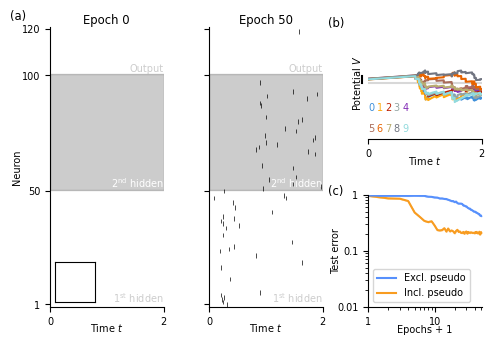

In [ ]:
### Figure
fig = plt.figure(figsize=cm2inch(1.5 * 8.6, 1.5 * 6.0))
gs = gridspec.GridSpec(
    2,
    3,
    figure=fig,
    hspace=0.5,
    wspace=0.4,
    top=0.94,
    bottom=0.15,
    left=0.12,
    right=0.97,
)

#### Spike plot before learning
ax = fig.add_subplot(gs[:, 0])
plot_spikes(ax, example_init, config_theta)
ax.set_title("Epoch 0", pad=-1)
axins = inset_axes(ax, width=0.4, height=0.4, loc="lower left")
# axins.imshow(example_init["input"].reshape(28, 28), cmap="gray")
axins.set_xticks([])
axins.set_yticks([])
axins.spines["top"].set_visible(True)
axins.spines["right"].set_visible(True)
panel_label(fig, ax, "(a)", x=-0.4, y=0.07)

#### Spike plot after learning
ax = fig.add_subplot(gs[:, 1])
plot_spikes(ax, example_end, config_theta)
ax.set_title(f"Epoch {config_theta['Nepochs']}", pad=-1)
ax.tick_params(labelleft=False)
ax.set_ylabel("")

### Trace output
ax = fig.add_subplot(gs[0, 2])
plot_traces(ax, example_end, config_theta)
panel_label(fig, ax, "(b)", x=-0.4, y=0.0)

### Accuracy plot
ax = fig.add_subplot(gs[1, 2])
plot_error(ax, metrics, config_theta)
panel_label(fig, ax, "(c)", x=-0.4, y=0.0)

plt.show()